# Kaggle - Fred(Lefan) Cheng - IEEE-CIS Fraud Detection

## 1.Business Problem
### 1.1 Problem Statement
- In day today's electronic world ,almost everyone make a transaction either in shopping mall or in booking movie tickets or flight tickets etc.So fraud transaction can happen in any of these places which will penalize the customer heavily as well as the businesses. Hence improving the efficacy of fraudulent transaction alerts for millions of people around the world and helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue.

## 2. Machine Learning Problem
### 2.1 Data
### 2.1.1 Data Overview
- The data contains 2 csv file one for transaction and another for identity.
- Train file of identity contains 144233 rows and 41 features.
- Train file of transaction contains 590540 rows and 394 features.
- Source: https://www.kaggle.com/c/ieee-fraud-detection/data

### 2.1.2 Data description
**For identity file**
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- The fields are masked due to security purposes.
- Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38
- Source : https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-592110

**For transaction file**
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. - The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Source : https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-592110

## 3. Exploratory Data Analysis

Import Libraries and Functions

In [ ]:
# Basic
import pandas as pd
import numpy as np

In [ ]:
# Plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
# Others
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 500)
import gc

In [2]:


  # import matplotlib.gridspec as gridspec
  # from IPython.core.pylabtools import figsize
# import time
# import datetime
import gc
# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
# ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import lightgbm as lgb
import xgboost as xgb
# Perfromance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [3]:
# Reducing memory usage
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
# Summarize Data
# From kernel https://www.kaggle.com/kabure/eda-feat-engineering-encode-conquer
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Data loading and overview

In [5]:
%%time
folder_path = '/Users/abc/Desktop/NYCDSA/Capstone/ieee-fraud-detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
# combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 1min 5s, sys: 23.7 s, total: 1min 29s
Wall time: 1min 38s


In [6]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


We have two medium-sized datasets with a lot of columns. Train and test data have similar number of rows

In [6]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [6]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
del train_identity, train_transaction, test_identity, test_transaction

In [8]:
train.sample(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
383651,3370651,0,9602988,44.096,C,15885,545.0,185.0,visa,138.0,debit,NaN,NaN,NaN,69.0,gmail.com,gmail.com,3.0,4.0,0.0,2.0,0.0,2.0,2.0,1.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.125000,0.125000,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,2.0,4.0,4.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,310.85141,310.85141,310.85141,135.220505,135.220505,135.220505,135.220505,135.220505,135.220505,44.096001,44.096001,44.096001,131.534897,131.534897,131.534897,3.0,3.0,3.0,2.0,4.0,4.0,1.0,1.0,1.0,0.0,1.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,1.0,310.85141,310.85141,310.85141,135.220505,135.220505,135.220505,0.0,135.220505,135.220505,135.220505,44.096001,44.096001,44.096001,131.534897,131.534897,131.534897,1.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,44.096001,44.096001,44.096001,0.0000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,44.096001,44.096001,44.096001,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
resumetable(train)

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29,59,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404,490,6.320000000000000
7,card3,float64,1565,114,150,150,150,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142,102,166,2.660000000000000


**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**

### Reducing memory usage

Notice that data types are changed

In [3]:
# Reducing memory usage
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
# %%time 
# train = reduce_mem_usage2(train)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 530.08 MB
Decreased by 73.0%
CPU times: user 1min 42s, sys: 1min 37s, total: 3min 20s
Wall time: 3min 21s


In [35]:
resumetable(train)

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,category,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,category,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


### Missing value

In [15]:
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values, which is {round(train.isnull().any().sum()/train.shape[1],4)*100}% percent of the whole training dataset.')

There are 414 columns in train dataset with missing values, which is 95.39% percent of the whole training dataset.


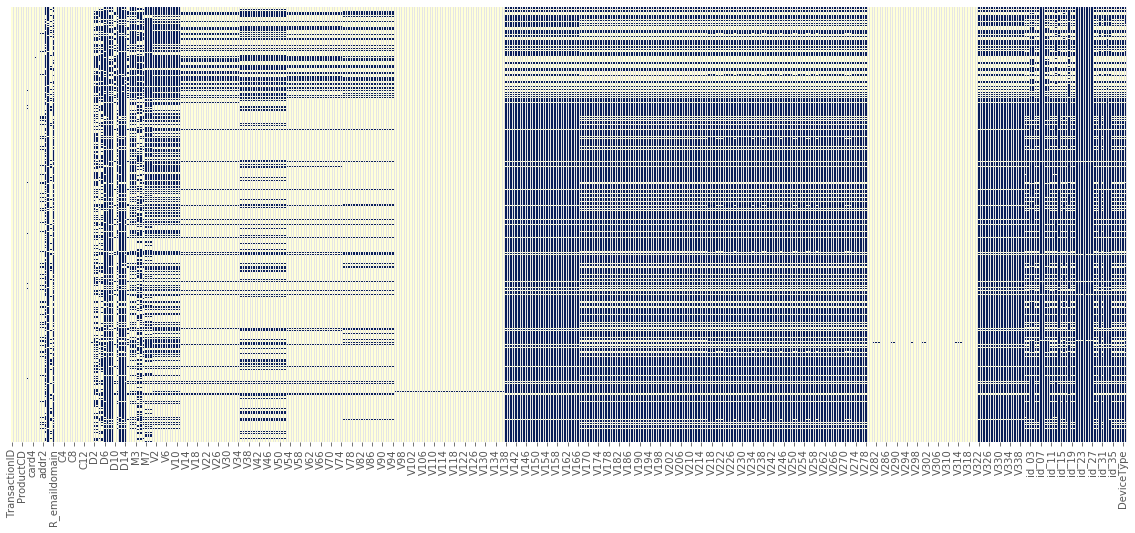

In [12]:
plt.figure(figsize=(20,8))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap = 'YlGnBu')

### Target distribution

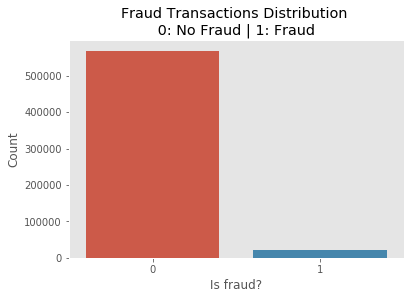

In [68]:
x = train['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud ")
plt.xlabel('Is fraud?')
plt.ylabel('Count');

This is clearly a class imbalace problem.

In [55]:
print('{:.2f}% of Transactions that are fraud in train'.format(train['isFraud'].mean() * 100))

3.50% of Transactions that are fraud in train 


## Data Exploration

### Transaction data

- ### TransactionDT - A timedelta of transactions from a given reference datetime 

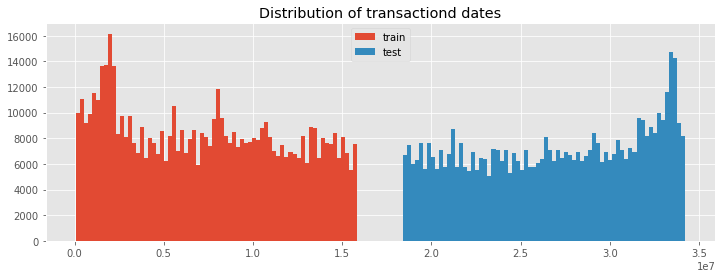

In [16]:
plt.figure(figsize=(12,4))
plt.hist(train['TransactionDT'], label='train',bins=70)
plt.hist(test['TransactionDT'], label='test',bins=70)
plt.legend()
plt.title('Distribution of transactiond dates');

It seems that train and test transaction dates don't overlap, so it would be prudent to use time-based split for validation.

In [197]:
#reference: https://www.kaggle.com/c/ieee-fraud-detection/discussion/100071#latest-577632
train_span = (train['TransactionDT'].max() - train['TransactionDT'].min())/(3600*24)
test_span = (test['TransactionDT'].max() - test['TransactionDT'].min())/(3600*24)
total_span = (test['TransactionDT'].max() - train['TransactionDT'].min())/(3600*24)
gap_span = (test['TransactionDT'].min() - train['TransactionDT'].max())/(3600*24)
print('Time span of Train dataset is {:.2f} days'.format(train_span))
print('Time span of Test dataset is {:.2f} days'.format(test_span))
print('Time span of Total dataset is {:.2f} days'.format(total_span))
print('Time gap between train and test is {:.2f} days'.format(gap_span))

Time span of Train dataset is 182.00 days
Time span of Test dataset is 183.00 days
Time span of Total dataset is 395.00 days
Time gap between train and test is 30.00 days


**Create day and hour features**

In [17]:
#Creating a 'day' feature
train['day'] = (train['TransactionDT']//(3600*24)-1)%7
test['day'] = (test['TransactionDT']//(3600*24)-1)%7
#Then creating a 'hour' feature
train['hour'] = (train['TransactionDT']//(3600))%24
test['hour'] = (test['TransactionDT']//(3600))%24

In [18]:
train['day'].value_counts()

0    98502
6    86377
3    85433
5    85356
4    84815
1    79834
2    70223
Name: day, dtype: int64

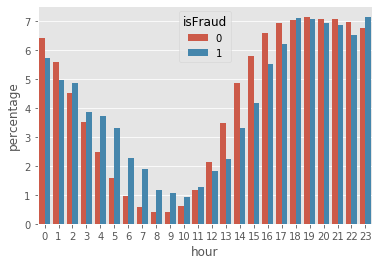

In [19]:
train_hour = (train.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))
sns.barplot(x="hour", y="percentage", hue="isFraud", data=train_hour);

- the hour from 4 to 9 rate of fraud transaction is more and from 9 to 18 rate of legit transaction is more.

- ### TransactionAmt

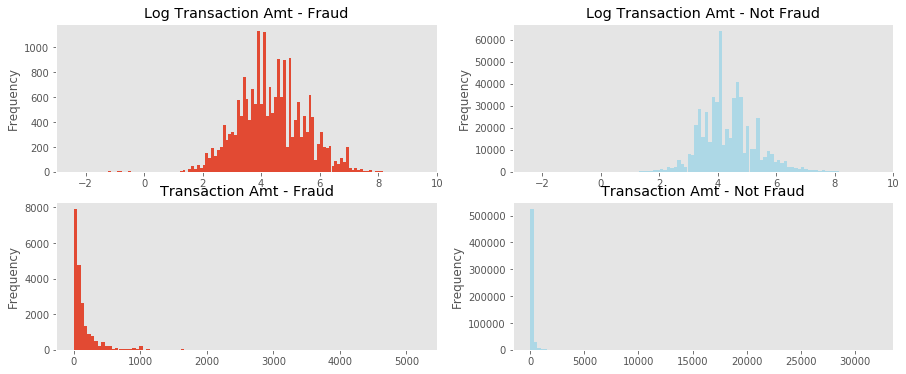

In [85]:
# Reference: https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda/notebook#Train-vs-Test-are-Time-Series-Split
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1]['TransactionAmt'].apply(np.log).plot(kind='hist',
                                                                      bins=100,
                                                                      title='Log Transaction Amt - Fraud',
                                                                      xlim=(-3, 10),ax= ax1)
train.loc[train['isFraud'] == 0]['TransactionAmt'].apply(np.log).plot(kind='hist',
                                                                      bins=100,
                                                                      title='Log Transaction Amt - Not Fraud',
                                                                      color='lightblue',
                                                                      xlim=(-3, 10),
                                                                      ax=ax2)
train.loc[train['isFraud'] == 1]['TransactionAmt'].plot(kind='hist',
                                                        bins=100,
                                                        title='Transaction Amt - Fraud',
                                                        ax=ax3)
train.loc[train['isFraud'] == 0]['TransactionAmt'].plot(kind='hist',
                                                        bins=100,
                                                        title='Transaction Amt - Not Fraud',
                                                        color='lightblue',
                                                        ax=ax4)
plt.show()

In [103]:
def my_mean(x): #.mean() returns inf and nan
    return np.average(x, weights=np.ones_like(x) / x.size)
print('Mean transaction amt for fraud is {:.4f}'.format(my_mean(train.loc[train['isFraud'] == 1]['TransactionAmt'])))
print('Mean transaction amt for non-fraud is {:.4f}'.format(my_mean(train.loc[train['isFraud'] == 0]['TransactionAmt'])))

Mean transaction amt for fraud is 149.2443
Mean transaction amt for non-fraud is 134.5119


- Fraudulent transactions appear to have a higher average transaction ammount

In [104]:
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(train['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


In [107]:
print(pd.concat([train[train['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 train[train['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "Not Fraud"]))

  Fraud                Not Fraud               
  index TransactionAmt     index TransactionAmt
0  0.01       6.739453      0.01       9.511875
1  0.10      18.937500      0.10      26.312500
2  0.25      35.031250      0.25      43.968750
3  0.50      75.000000      0.50      68.500000
4  0.75     161.000000      0.75     120.000000
5  0.90     335.000000      0.90     267.100000
6  0.99     994.000000      0.99    1104.000000


- ## Categorical Features - Transaction

We are told in the data description that the following transaction columns are categorical:

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

- ### ProductCD

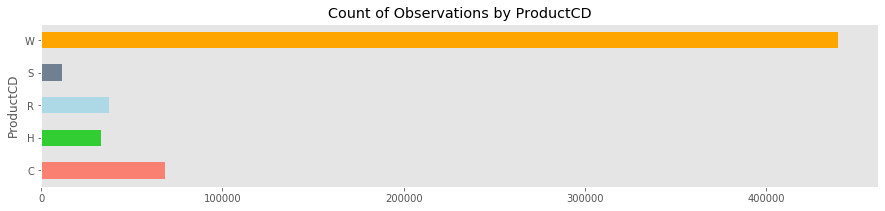

In [142]:
train.groupby('ProductCD')['TransactionID'].count().sort_index().plot(kind='barh',
                                                                      figsize=(15, 3),
                                                                      title='Count of Observations by ProductCD',
                                                                      color=['salmon', 'limegreen', 'lightblue', 'slategrey','orange'])
plt.show()

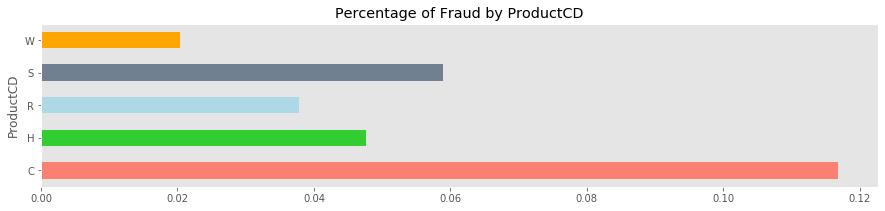

In [144]:
train.groupby('ProductCD')['isFraud'].mean().sort_index().plot(kind='barh',
                                                               figsize=(15, 3),
                                                               title='Percentage of Fraud by ProductCD',
                                                               color=['salmon', 'limegreen', 'lightblue', 'slategrey','orange'])
plt.show()

In [160]:
train.groupby('ProductCD')['isFraud'].mean().sort_values(ascending=False)

ProductCD
C    0.116873
S    0.058996
H    0.047662
R    0.037826
W    0.020399
Name: isFraud, dtype: float64

- W has the most number of observations, S the least.
- ProductCD C has the most fraud with >11%
- ProductCD W has the least with ~2%

- ### card1 - card6

In [201]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


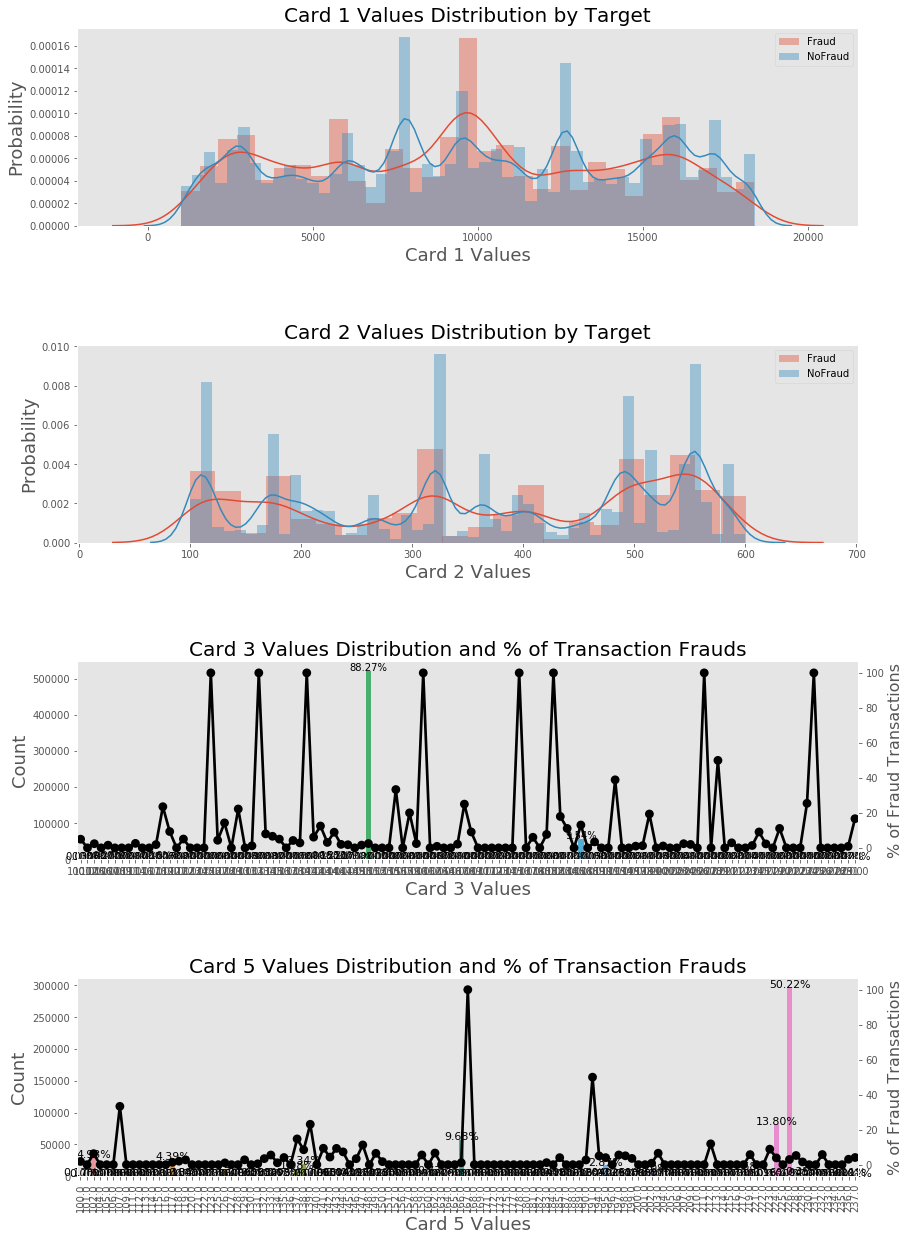

In [228]:
tmp = pd.crosstab(train['card3'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train['card5'], train['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(train[train['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train[train['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(train[train['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train[train['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=train, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
total = len(train)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=train, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

In Card3 we can see that 150 and 185 are the most common values in the column.
We have ~2.2% of Frauds in 150 and ~13.5% in 185; The values with highest Fraud Transactions are 185, 144 and 119;

In card5 the most frequent values are 226, 224, 166 that represents 73% of data. Also is posible to see high % of frauds in 137, 147, 141 that has few entries for values.

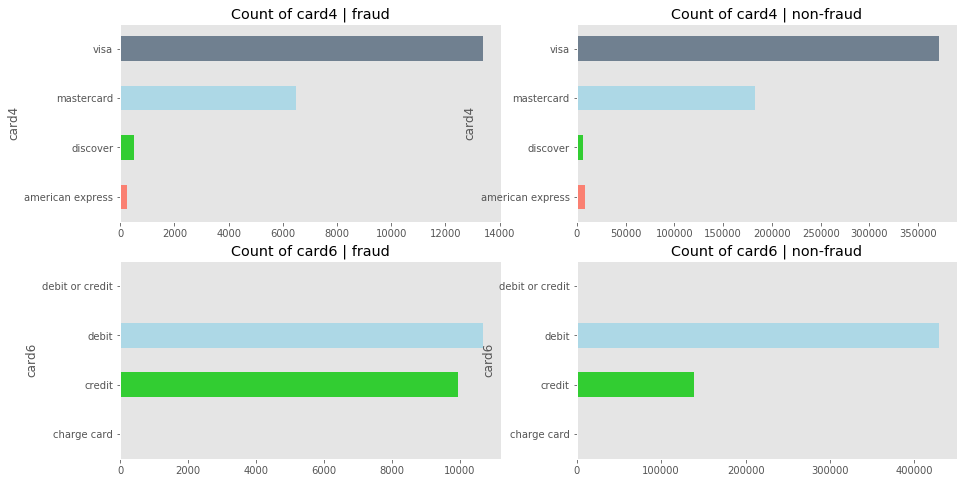

In [212]:
train_transaction_fr = train.loc[train['isFraud'] == 1]
train_transaction_nofr = train.loc[train['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 | fraud', color=['salmon', 'limegreen', 'lightblue', 'slategrey'])
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 | non-fraud', color=['salmon', 'limegreen', 'lightblue', 'slategrey'])
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 | fraud', color=['salmon', 'limegreen', 'lightblue', 'slategrey'])
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 | non-fraud', color=['salmon', 'limegreen', 'lightblue', 'slategrey'])
plt.show()

It appears that credit card has higher fraudulent transaction percentage

- ### addr1 & addr2

In [214]:
print(' addr1 - has {} NA values'.format(train['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


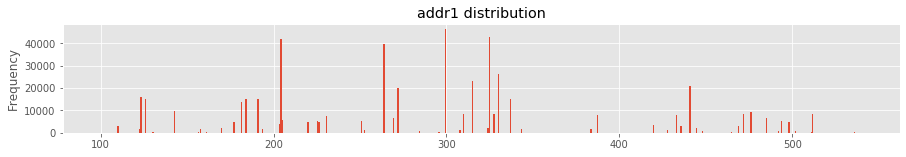

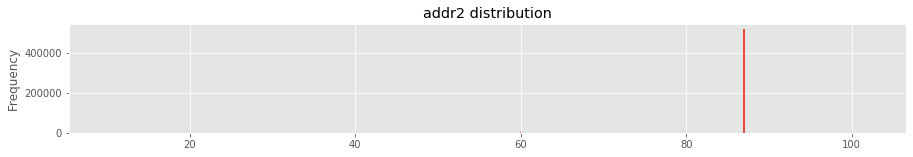

In [218]:
train['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution',grid=True)
plt.show()
train['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution',grid=True)
plt.show()

- ### dist1 & dist2

Possibly this could be the distance of the transaction vs. the card owner's home/work address. This is just a guess. I guess this distance could be a important feature for fraud detection.

## Modeling

In [59]:
# impute all missing value with -999
def fillna(df):
    df.fillna(-999, inplace = True)
fillna(train)
fillna(test)

In [41]:
# List all categorical features
categorical_features = []
for i in dict(train.dtypes):
    if dict(train.dtypes)[i] == 'object':
        categorical_features.append(i)
print(categorical_features)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [71]:
# Label encoding
le = preprocessing.LabelEncoder()
for i in categorical_features:
    le.fit(train[i].astype(str))
    encoded_feature = le.transform(train[i].astype(str))
    train[i] = encoded_feature
    le.fit(test[i].astype(str))
    encoded_feature = le.transform(test[i].astype(str))
    test[i] = encoded_feature
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,3663549,18403224,31.95,4,10409,111.0,150.0,4,226.0,3,170.0,87.0,1.0,-999.0,9,0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,-999.0,-999.0,-999.0,-999.0,418.0,203.0,-999.0,-999.0,-999.0,409.0,2,2,1,0,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,

In [72]:
train.shape

(590540, 436)

In [73]:
# Divide train set in to 2 parts in 70:30 ratio which are train_mode and cv_mod
train_mod = train[:413357]
cv_mod = train[413357:]

In [74]:
x_train = train_mod.drop(['isFraud'],axis=1)
y_train = train_mod['isFraud']
x_cv = cv_mod.drop(['isFraud'],axis=1)
y_cv = cv_mod['isFraud']

In [78]:
# Upsampling the imbalance with SMOTE
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel()) 

In [80]:
print(x_train_res.shape)
print(y_train_res.shape)

(797638, 435)
(797638,)


In [94]:
features = list(x_train.columns)

In [95]:
lgb_train = lgb.Dataset(x_train, y_train, feature_name = features, categorical_feature = categorical_features)

In [97]:
params = {
 'task': 'train'
 , 'boosting_type': 'gbdt'
 , 'objective': 'binary'
 , 'num_class': num_of_classes
 , 'metric': 'rmsle' if is_regression == True else 'multi_logloss'
 , 'min_data': 1
 , 'verbose': -1
}


lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255,
                    'verbose':-1,
                    'early_stopping_rounds':100, 
                }

gbm = lgb.train(params, lgb_train, num_boost_round=50)

NameError: name 'num_of_classes' is not defined

In [100]:
from lightgbm import LGBMModel,LGBMClassifier

In [101]:
clf = LGBMClassifier(objective='binary',
                    boosting_type='gbdt',
                    metric='auc',
                    n_jobs=-1,
                    learning_rate=0.01,
                    num_leaves= 2**8,
                    max_depth=-1,
                    tree_learner='serial',
                    colsample_bytree= 0.7,
                    subsample_freq=1,
                    subsample=0.7,
                    n_estimators=800,
                    max_bin=255,
                    verbose=-1)

In [102]:
clf.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.01, max_bin=255,
               max_depth=-1, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
               n_jobs=-1, num_leaves=256, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=1,
               tree_learner='serial', verbose=-1)

In [104]:
predict_ytest = clf.predict_proba(test)

In [21]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,

In [25]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']

In [17]:
# gc.collect()

322

In [15]:
# X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
# y = train.sort_values('TransactionDT')['isFraud']
# X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)

In [16]:
# def clean_inf_nan(df):
#     return df.replace([np.inf, -np.inf], np.nan)
# X = clean_inf_nan(X)
# X_test = clean_inf_nan(X_test)

Test on GBM

In [42]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [43]:
gbm = GradientBoostingClassifier()
gbm.fit(X,y)
gbm.score(X,Y)

ValueError: could not convert string to float: 'W'

In [23]:
# n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [24]:
folds

KFold(n_splits=5, random_state=None, shuffle=False)

In [32]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'categorical_feature': cat_cols
         }

# result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

Fold 1 started at Sun Dec  1 11:49:45 2019


NameError: name 'fast_auc' is not defined